$\newcommand{\vect}[1]{{|#1\rangle}}$
$\newcommand{\vectt}[1]{{\langle#1|}}$
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\z}{\mathbf{z}}$
$\newcommand{\s}{\mathbf{s}}$
$\newcommand{\zero}{\mathbf{0}}$
$\newcommand{\one}{\mathbf{1}}$


# Implementing Grover's Algorithm
ECS7011P - Quantum Programming - 2023/24

Author: Chin-Yun Yu

To run this notebook, the following packages are required:

- `qiskit`
- `qiskit-aer`
- `numpy`
- `matplotlib`

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_distribution
from typing import List, Tuple, Iterable
from functools import reduce, partial
import matplotlib.pyplot as plt
import math

simulator = AerSimulator()

## Abstract

Grover's algorithm is a quantum algorithm for searching an unsorted database and has a quadratic speedup over the best classical algorithm. 
In this notebook, we implement Grover's algorithm using Qiskit and demonstrate it on a simple unique search problem, with 16 possible solutions. 
The results show that after 3 queries, the probability of finding the correct solution is around $96\%$, while the classical algorithm requires on average $8$ queries.
Geometrical interpretation of Grover's algorithm using unit complex numbers and the relationship between inversion of the mean and Grover's algorithm are also discussed.

## Introduction

Unstructured search is a problem that is difficult to solve using classical computers. 
Withouth any additional information, the best way to find a solution is to try all possible solutions one by one, until the correct one is found.
Assuming that there are $2^N$ possible solutions, we have to try $2^{N-1}$ (half of the total number) solutions on average to find the correct one.
Grover's algorithm is a quantum algorithm that can solve this problem with a complexity of $O(2^{\frac{N}{2}})$.
This quadratic speedup can be a significant advantage when $N$ is large.

In this notebook, we will implement Grover's algorithm using Qiskit, and demonstrate how it works on a simple example.
The sections are organised as follows:
- In the [**Problem Statement**](#problem-statement) section, we will define the problem that Grover's algorithm is designed to solve.
- In the [**Methodology**](#methodology) section, we will describe the algorithm, how it works, and its geometric interpretation.
- In the [**Results and Discussions**](#results-and-discussions) section, we will implement the algorithm using Qiskit and run it on a 4-bit example.

The answers to coursework questions:
1. _What is the probability of getting the correct search item?_ Check the end of [this section](#interpreting-the-grovers-diffusion-operator).
2. _What happens if the number of iterations of the algorithm is too small or too large? Wil the performance improve?_ See [this section](#what-happen-when-t-is-not-optimal-question-2).
3. _Is the inversion of the mean used in this algorithm? If not why not, if yes how is implemented using unitary operators?_ See [this section](#relation-to-inversion-of-the-mean-operator-question-3).

## Problem Statement

Given a function $f: \{0, 1\}^N \rightarrow \{0, 1\}$, we want to find the value of $x$ such that $f(\x) = 1$.
In the context of searching in a database, we want to find the index $\x$ that exists in the database, whcih is represented by $f$.
Traditionally, we have to try all possible values $\x_0, \x_1, \ldots, \x_{2^N-1}$, until we find the correct one.

## Methodology

The way how Grover's algorithm solves the unstructured search problem is in the following steps.
Firstly, let's construct $f$ as a unitary operator $U_f$.
The operator $U_f$ is defined as follows:

$
\begin{align}
\mathbf{U}_f (\mathbf{I} \otimes \mathbf{H}) (\vect{\x} \otimes \vect{1})
&= |\x\rangle \otimes \left(\frac{1}{\sqrt{2}} \left(\vect{f(\x)} - \vect{\neg f(\x)}\right)\right) \\
&= (-1)^{f(\x)} |\x\rangle \otimes |-\rangle,
\end{align}
$
where we used the basis state $\vect{-}$ to denote $\frac{1}{\sqrt{2}} (\vect{0} - \vect{1})$.
The detailed derivation can be found in the week 6 lecture slides.
Basically, this operator flips the sign of input $\vect{\x}$ if $f(\x) = 1$, telling us we found the solution.
Let's implement the operator $U_f$ in Qiskit.


In [2]:
def oracle(marked_states: List[str], name="oracle") -> QuantumCircuit:
    """
    Returns a quantum circuit that marks the given states.
    """
    n_bits = len(marked_states[0])

    assert all(
        len(marked_states[0]) == len(state) for state in marked_states
    ), "All marked states must have the same length"

    # allocate n qubits for the input and one for the output
    qc = QuantumCircuit(n_bits + 1, n_bits, name=name)
    qc.barrier()

    # if the input match one of the marked states, the output sign will be flipped
    def f(qc: QuantumCircuit, target: str) -> QuantumCircuit:
        rev_target = target[::-1]
        zero_inds = list(filter(lambda i: rev_target[i] == "0", range(n_bits)))
        # flip the zero bits
        qc.x(zero_inds)
        # flip the sign of |-> if the input is the marked state
        qc.mcx(list(range(n_bits)), n_bits)
        # flip the bits back
        qc.x(zero_inds)
        return qc

    qc = reduce(f, marked_states, qc)
    qc.barrier()
    return qc


example_oracle = oracle(["010", "101"])
example_oracle.draw()

░ ┌───┐     ┌───┐           ░ 
q_0: ─░─┤ X ├──■──┤ X ├──■────────░─
      ░ └───┘  │  ├───┤  │  ┌───┐ ░ 
q_1: ─░────────■──┤ X ├──■──┤ X ├─░─
      ░ ┌───┐  │  ├───┤  │  └───┘ ░ 
q_2: ─░─┤ X ├──■──┤ X ├──■────────░─
      ░ └───┘┌─┴─┐└───┘┌─┴─┐      ░ 
q_3: ─░──────┤ X ├─────┤ X ├──────░─
      ░      └───┘     └───┘      ░ 
c: 3/═══════════════════════════════

In the above example, we built a three bits oracle function that will flip the sign of output register $\vect{-}$ if the input is either $\vect{010}$ or $\vect{101}$.
Here we use the fact that $\mathbf{X}\vect{-} = -\vect{-}$.
But, how can we efficiently found the solution without enumerating all possible inputs?
This is where Grover's algorithm comes in.

### Grover's Algorithm

The algorithm consists of the following steps:

1. Initialize the state to $\vect{\s} = \frac{1}{\sqrt{2^N}} \sum_{\x \in \{0, 1\}^N} \vect{\x} = \mathbf{H}\vect{0\ldots0}$. The output bit is initialized to $\vect{-} = \mathbf{H}\mathbf{X}\vect{0}$.
2. Apply the operator $U_f$ to the input bits.
3. Perform the Grover's diffusion operator $\mathbf{H} \mathbf{U}_0 \mathbf{H}$, where $\mathbf{U}_0$ is the zero oracle operator that only flips the sign when the input is $\vect{0\ldots0}$.
4. Repeat steps 2 and 3 for $T$ times, where $T$ is a number depends on the number of solutions and the search space size.

The algorithm increase the probability of getting one of the solutions when we measure the state after step 4.

### Geometrical Interpretation

Let's represent the solution space as a union of two subspaces $\{0, 1\}^N = S \cup \neg S$, where $S = \{\x \in \{0, 1\}^N : f(\x) = 1\}$.
We can use these two sets to define two vectors that are orthogonal to each other.

$
\begin{align}
\vect{Re} = \frac{1}{\sqrt{|\neg S|}} \sum_{\x \in \neg S} \vect{\x},~\
\vect{Im} = \frac{1}{\sqrt{|S|}} \sum_{\x \in S} \vect{\x}.
\end{align}
$

We name the two vectors as the two axis of the complex plane for convenience, which you will see why in a moment, as all the following steps only operate on the unit circle spanned by these two vectors.
The initial state $\vect{s}$ can be written as a linear combination of the two basis vectors:
$
\begin{align}
\vect{\s} = \frac{1}{\sqrt{2^N}} \sum_{\x \in \{0, 1\}^N} \vect{\x} 
&= \frac{1}{\sqrt{|S| + |\neg S|}} \left(\sum_{\x \in S} \vect{\x} + \sum_{\x \in \neg S} \vect{\x}\right) \\
&= \sqrt{\frac{|\neg S|}{2^N}} \vect{Re} + \sqrt{\frac{|S|}{2^N}} \vect{Im}.
\end{align}
$
We can represent it as a complex number using Euler's formula $e^{i\theta_s} = \cos(\theta_s) + i\sin(\theta_s)$ where $\vect{Re} \equiv 1$, $\vect{Im} \equiv i$, and the angle $\theta_s = \sin^{-1}\left(\sqrt{\frac{|S|}{2^N}}\right)$.

#### Interpreting the oracle operator

The oracle operator $U_f$ can be represented as $2 \vect{Re}\vectt{Re} - \mathbf{I}$.
This is easy to see, as the operator flips the sign of the input state if it is in the solution space, and does nothing otherwise.
$
\begin{align}
\mathbf{U}_f \vect{Re} &= 2 \vect{Re}\vectt{Re}\vect{Re} - \vect{Re} = \vect{Re}, \\
\mathbf{U}_f \vect{Im} &= 2 \vect{Re}\vectt{Re}\vect{Im} - \vect{Im} = -\vect{Im}.
\end{align}
$
Using the complex number representation, we can see that the operator $U_f$ taking the conjugate of the input:
$
\begin{equation}
U_f e^{i\theta} = e^{-i\theta}.
\end{equation}
$

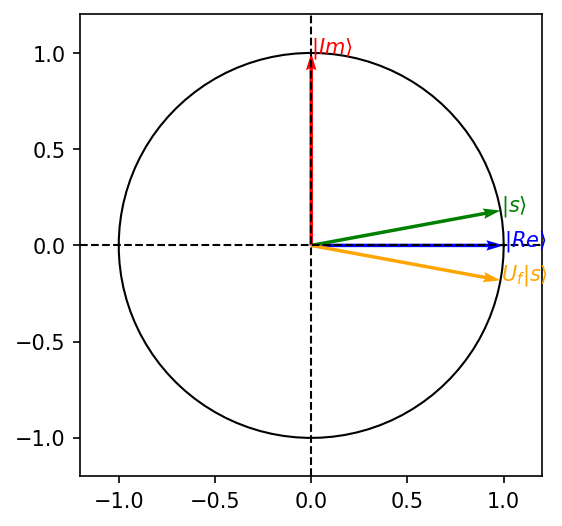

In [3]:
def unit_circle(ax):
    """
    Plots the unit circle on a given axis.
    """
    theta = np.linspace(0, 2 * np.pi, 100)
    x = np.cos(theta)
    y = np.sin(theta)
    ax.plot(x, y, color="black", linewidth=1)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect("equal", adjustable="box")
    ax.hlines(0, -1.2, 1.2, color="black", linestyle="--", linewidth=1)
    ax.vlines(0, -1.2, 1.2, color="black", linestyle="--", linewidth=1)
    return


def plot_vector(ax, vector: np.ndarray, label: str, color: str):
    """
    Plots a vector on a given axis.
    """
    ax.quiver(
        0, 0, vector[0], vector[1], angles="xy", scale_units="xy", scale=1, color=color
    )
    ax.text(vector[0], vector[1], label, color=color)
    return


theta_s = math.pi * 0.058
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
unit_circle(ax)
plot_vector(ax, [1, 0], r"$|Re\rangle$", "blue")
plot_vector(ax, [0, 1], r"$|Im\rangle$", "red")
plot_vector(ax, [math.cos(theta_s), math.sin(theta_s)], r"$|s\rangle$", "green")
plot_vector(ax, [math.cos(theta_s), -math.sin(theta_s)], r"$U_f|s\rangle$", "orange")
plt.show()

#### Interpreting the Grover's diffusion operator

Similarly, we can represent the zero oracle operator $U_0$ as $2 \vect{0\ldots0}\vectt{0\ldots0} - \mathbf{I}$.
Moreover, 

$
\begin{align}
\mathbf{H} \mathbf{U}_0 \mathbf{H} 
= 2 \mathbf{H} \vect{0\ldots0}\vectt{0\ldots0} \mathbf{H} - \mathbf{H} \mathbf{H} 
= 2 \vect{\s}\vectt{\s} - \mathbf{I}.
\end{align}
$

The form of $2 \vect{\x}\vectt{\x} - \mathbf{I}$ is a reflection operator that reflects the state about the axis $\vect{\x}$. 
This is easy to see as the operator consists of two parts: firstly, $\vect{\x}\vectt{\x}$ projects the input state onto the axis $\vect{\x}$, and then $\vect{\x}\vectt{\x} - \mathbf{I}$ add the difference between the input state and the projection on $\vect{\x}$, equals to the reflection about the axis $\vect{\x}$.
In $U_f$, the axis is the real axis, and the reflection about the real axis is the conjugate operation. 
Because it's a unitary operator, the output state stays on the unit circle.
Only the phase of the state is changed ($\theta_{out} = \theta_x + (\theta_x - \theta_{in}) = 2\theta_x - \theta_{in}$).
Thus, the diffusion operator is:

$
\begin{align}
H U_0 H e^{i\theta} = e^{i(2\theta_s - \theta)}.
\end{align}
$

Let's chain the two operators together and see what happens to the state $\vect{\s}$ in the first iteration:

$
\begin{align}
H U_0 H U_f e^{i\theta_s} = H U_0 H e^{-i\theta_s} = e^{i3\theta_s}.
\end{align}
$
We see the state is rotated by $2\theta_s$ after the first iteration.

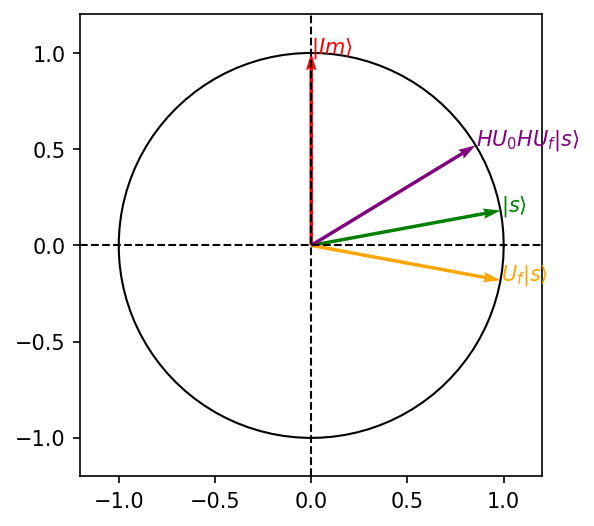

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
unit_circle(ax)
plot_vector(ax, [0, 1], r"$|Im\rangle$", "red")
plot_vector(ax, [math.cos(theta_s), math.sin(theta_s)], r"$|s\rangle$", "green")
plot_vector(ax, [math.cos(theta_s), -math.sin(theta_s)], r"$U_f|s\rangle$", "orange")
plot_vector(
    ax, [math.cos(3 * theta_s), math.sin(3 * theta_s)], r"$HU_0HU_f|s\rangle$", "purple"
)
plt.show()

Let's apply the operator again and see what happens (we use $U_d = H U_0 H$ for brevity):

$
\begin{align}
U_d U_f e^{i3\theta_s} = U_d e^{-i3\theta_s} = e^{i5\theta_s}.
\end{align}
$

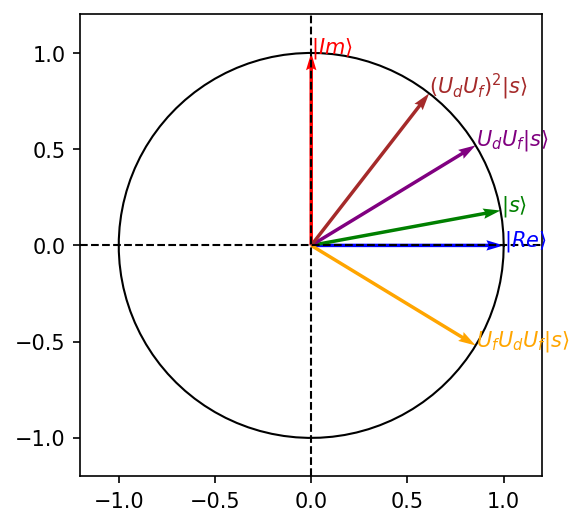

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
unit_circle(ax)
plot_vector(ax, [1, 0], r"$|Re\rangle$", "blue")
plot_vector(ax, [0, 1], r"$|Im\rangle$", "red")
plot_vector(ax, [math.cos(theta_s), math.sin(theta_s)], r"$|s\rangle$", "green")
plot_vector(
    ax, [math.cos(3 * theta_s), math.sin(3 * theta_s)], r"$U_dU_f|s\rangle$", "purple"
)
plot_vector(
    ax,
    [math.cos(3 * theta_s), -math.sin(3 * theta_s)],
    r"$U_fU_dU_f|s\rangle$",
    "orange",
)
plot_vector(
    ax,
    [math.cos(5 * theta_s), math.sin(5 * theta_s)],
    r"$(U_dU_f)^2|s\rangle$",
    "brown",
)
plt.show()

As the time goes on, the state becomes closer to the solution state $\vect{Im}$ on the imaginary axis, and the probability of measuring the solution state (its projection on the imaginary axis) increases, which is $\sin^2((2T + 1)\theta_s)$ (**question 1**).

## Results and Discussions

Let's design a toy example to see how Grover's algorithm works.
We'll use a 4-bit oracle function the size of the search space is $2^4 = 16$.
The solution is $\vect{1010}$.

In [6]:
num_qbits = 4
marked_states = ["1010"]
U_f = oracle(marked_states)
U_f.draw()

░ ┌───┐     ┌───┐ ░ 
q_0: ─░─┤ X ├──■──┤ X ├─░─
      ░ └───┘  │  └───┘ ░ 
q_1: ─░────────■────────░─
      ░ ┌───┐  │  ┌───┐ ░ 
q_2: ─░─┤ X ├──■──┤ X ├─░─
      ░ └───┘  │  └───┘ ░ 
q_3: ─░────────■────────░─
      ░      ┌─┴─┐      ░ 
q_4: ─░──────┤ X ├──────░─
      ░      └───┘      ░ 
c: 4/═════════════════════

The optimal number of iterations $T^*$ is when $\sin^2$ is maximised, which means $(2T^*+1)\theta_s \approx \frac{\pi}{2}$, implies that

$
\begin{align}
T^* = \left\lfloor \frac{\pi}{4\theta_s} - \frac{1}{2} \right\rceil = \left\lfloor \frac{\pi}{4\sin^{-1}\left(\sqrt{\frac{|S|}{2^N}}\right)} \right\rfloor.
\end{align}
$

When only one solution is present ($|S| = 1$), we can approximate $\sin^{-1}(\sqrt{\frac{1}{2^N}}) \approx 2^{-\frac{N}{2}}$ using the fact that $\lim_{x \rightarrow 0} \frac{\sin^{-1}(x)}{x} = 1$ when $N$ is large.
Therefore, the optimal number of iterations is $T^* \approx \pi 2^{\frac{N}{2} - 2} $.
For $N = 4$, $T^* = \lfloor \pi \rfloor = 3$.

In [7]:
def num_iters(n_bits: int, n_marked: int = 1) -> int:
    if n_marked > 1:
        return int(math.pi * 0.25 / math.asin(math.sqrt(n_marked / 2**n_bits)))
    return int(math.pi * 2 ** (n_bits / 2 - 2))


iters = num_iters(num_qbits, len(marked_states))
print(f"T^* = {iters}")

T^* = 3


Let's construct the whole algorithm as a quantum circuit and see how it works.
We measure the input registers at the end to see if we get the solution state.

In [8]:
def get_zor(n_bits: int) -> QuantumCircuit:
    return oracle(["0" * n_bits])


def idx2bits(idx: int, n_bits: int) -> str:
    return format(idx, f"0{n_bits}b")


def bits2idx(bits: str) -> int:
    return int(bits, 2)


def apply_grovers(U_f: QuantumCircuit, n_iters: int) -> QuantumCircuit:
    n_bits = U_f.num_qubits - 1
    qc = QuantumCircuit(n_bits + 1, n_bits)
    # initialize the state to all zeros
    qc.initialize("0" * (n_bits + 1))
    # negate the last qubit for sign flip
    qc.x(n_bits)
    # apply hadamard to all qubits
    qc.h(range(n_bits + 1))

    # Grover's diffusion operator
    diffuser = QuantumCircuit(n_bits + 1, n_bits, name="diffuser")
    diffuser.h(range(n_bits))
    U_zero = oracle(["0" * n_bits], name="diffuser")
    diffuser.compose(U_zero, inplace=True)
    diffuser.h(range(n_bits))

    def iter(qc: QuantumCircuit) -> QuantumCircuit:
        # apply U_f
        qc.compose(U_f, inplace=True)
        # apply the diffusion operator
        qc.compose(diffuser, inplace=True)
        return qc

    qc = reduce(lambda x, _: iter(x), range(n_iters), qc)
    return qc


full_grovers_qc = apply_grovers(oracle(marked_states), iters)
full_grovers_qc.measure(range(num_qbits), range(num_qbits))
full_grovers_qc.draw()

┌────────────────────────┐┌───┐      ░ ┌───┐     ┌───┐ ░ ┌───┐ ░ ┌───┐»
q_0: ┤0                       ├┤ H ├──────░─┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├»
     │                        │├───┤      ░ └───┘  │  └───┘ ░ ├───┤ ░ ├───┤»
q_1: ┤1                       ├┤ H ├──────░────────■────────░─┤ H ├─░─┤ X ├»
     │                        │├───┤      ░ ┌───┐  │  ┌───┐ ░ ├───┤ ░ ├───┤»
q_2: ┤2 Initialize(0,0,0,0,0) ├┤ H ├──────░─┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├»
     │                        │├───┤      ░ └───┘  │  └───┘ ░ ├───┤ ░ ├───┤»
q_3: ┤3                       ├┤ H ├──────░────────■────────░─┤ H ├─░─┤ X ├»
     │                        │├───┤┌───┐ ░      ┌─┴─┐      ░ └───┘ ░ └───┘»
q_4: ┤4                       ├┤ X ├┤ H ├─░──────┤ X ├──────░───────░──────»
     └────────────────────────┘└───┘└───┘ ░      └───┘      ░       ░      »
c: 4/══════════════════════════════════════════════════════════════════════»
                                                                           »
«          ┌───┐ ░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐ ░ »
«q_0: ──■──┤ X ├─░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─░─»
«       │  ├───┤ ░ ├───┤ ░ └───┘  │  └───┘ ░ ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤ ░ »
«q_1: ──■──┤ X ├─░─┤ H ├─░────────■────────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─░─»
«       │  ├───┤ ░ ├───┤ ░ ┌───┐  │  ┌───┐ ░ ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤ ░ »
«q_2: ──■──┤ X ├─░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─░─»
«       │  ├───┤ ░ ├───┤ ░ └───┘  │  └───┘ ░ ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤ ░ »
«q_3: ──■──┤ X ├─░─┤ H ├─░────────■────────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─░─»
«     ┌─┴─┐└───┘ ░ └───┘ ░      ┌─┴─┐      ░ └───┘ ░ └───┘┌─┴─┐└───┘ ░ └───┘ ░ »
«q_4: ┤ X ├──────░───────░──────┤ X ├──────░───────░──────┤ X ├──────░───────░─»
«     └───┘      ░       ░      └───┘      ░       ░      └───┘      ░       ░ »
«c: 4/═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«     ┌───┐     ┌───┐ ░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐┌─┐         
«q_0: ┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├┤M├─────────
«     └───┘  │  └───┘ ░ ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤└╥┘┌─┐      
«q_1: ───────■────────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─╫─┤M├──────
«     ┌───┐  │  ┌───┐ ░ ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤ ║ └╥┘┌─┐   
«q_2: ┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─╫──╫─┤M├───
«     └───┘  │  └───┘ ░ ├───┤ ░ ├───┤  │  ├───┤ ░ ├───┤ ║  ║ └╥┘┌─┐
«q_3: ───────■────────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├─╫──╫──╫─┤M├
«          ┌─┴─┐      ░ └───┘ ░ └───┘┌─┴─┐└───┘ ░ └───┘ ║  ║  ║ └╥┘
«q_4: ─────┤ X ├──────░───────░──────┤ X ├──────░───────╫──╫──╫──╫─
«          └───┘      ░       ░      └───┘      ░       ║  ║  ║  ║ 
«c: 4/══════════════════════════════════════════════════╩══╩══╩══╩═
«                                                       0  1  2  3

The probability the algorithm finds the solution after three iterations is $\sin^2(7\theta_s) = (-\sin(\theta_s) (56\sin^2(\theta_s) - 112 \sin^4(\theta) -7 + 64\sin^6(\theta_s)))^2$. Let's see what's the exact number of it.

In [9]:
seven_angle_sin = partial(np.polyval, [-64, 0, 112, 0, -56, 0, 7, 0])

print(
    f"The probability of finding the solution with T = 3 is {seven_angle_sin(0.25) ** 2}"
)

The probability of finding the solution with T = 3 is 0.9613189697265625


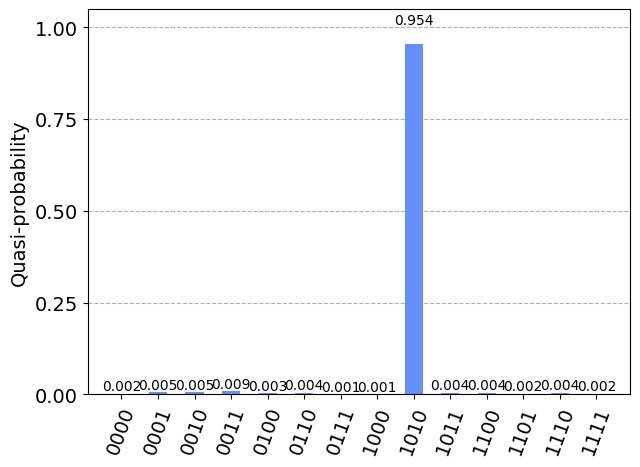

In [10]:
results = simulator.run(full_grovers_qc, shots=1000).result()
answer = results.get_counts()
counts2probs = lambda counts: (
    lambda scaler: {k: v / scaler for k, v in counts.items()}
)(sum(counts.values()))
probs = counts2probs(answer)
plot_distribution(probs)

After sampling 1000 times, we can see that the probability of finding $\vect{1010}$ is very close to 0.96, which is consistent with the theoretical prediction.

### What happen when T is not optimal (**question 2**)?

We have shown that the probability $\sin^2((2T + 1)\theta_s): T \in \left[0, \lfloor\frac{\pi}{2\theta_s} - \frac{1}{2}\rfloor\right]$ is maximised when $T = T^*$.
Any $T \neq T^*$ will result in a lower probability of finding the solution.

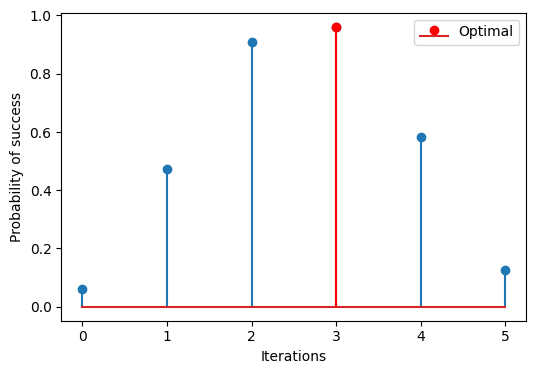

In [11]:
five_angle_sin = partial(np.polyval, [16, 0, -20, 0, 5, 0])
n_angle_sin = lambda sina, n: (((1 - sina**2) ** 0.5 + 1j * sina) ** n).imag

t = list(range(int(math.pi / 2 / math.asin(0.25) - 0.5) + 1))
y = list(
    map(lambda x: x * x, map(partial(n_angle_sin, 0.25), map(lambda x: 2 * x + 1, t)))
)
fig = plt.figure(figsize=(6, 4), dpi=100)
plt.stem(t, y)
plt.stem([iters], [seven_angle_sin(0.25) ** 2], "r", label="Optimal")
plt.xlabel("Iterations")
plt.ylabel("Probability of success")
plt.legend()
plt.show()

 Because $\sin^2$ is periodic with a period of $\pi$, we could find other $T > T^*$ that gives high probability.
 Let's see what happens when $T = 9$.

In [12]:
print(
    f"The probability of finding the solution with T = 9 is {n_angle_sin(0.25, 19)**2}"
)

The probability of finding the solution with T = 9 is 0.9921818600205397


Although the probability is higher than the case of $T^* = 3$, it needs more iterations to reach that, and 9 is greater than the average number of evaluations to find the solution $\frac{16}{2} = 8$ without quantum computing, so it's not a good choice.
Moreover, with larger $N$, the $\sin^2$ is sampled more densely, so the probability differences between $T^*$ and other modes become smaller.

### Relation to _inversion of the mean_ operator (**question 3**)

In [previous section](#interpreting-the-grover-diffusion-operator), we showed that the Grover's diffusion operator is a reflection about the state $\vect{\s}$ and is composed of $\vect{\s}\vectt{\s}$ and $\vect{\s}\vectt{\s} - \mathbf{I}$.
Let's interpret the operator from a slightly different perspective, which is the _inversion of the mean_ operator.

If we expand the operators, we have

$
\begin{align}
\vect{\s}\vectt{\s} &= 
\begin{vmatrix}
\frac{1}{2^N} & \frac{1}{2^N} & \cdots & \frac{1}{2^N} \\
\frac{1}{2^N} & \frac{1}{2^N} & \cdots & \frac{1}{2^N} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{1}{2^N} & \frac{1}{2^N} & \cdots & \frac{1}{2^N}
\end{vmatrix}, \\
\vect{\s}\vectt{\s} - \mathbf{I} &=
\begin{vmatrix}
\frac{1}{2^N} - 1 & \frac{1}{2^N} & \cdots & \frac{1}{2^N} \\
\frac{1}{2^N} & \frac{1}{2^N} - 1 & \cdots & \frac{1}{2^N} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{1}{2^N} & \frac{1}{2^N} & \cdots & \frac{1}{2^N} - 1
\end{vmatrix}.
\end{align}
$

What we see is that the operator $\vect{\s}\vectt{\s}$ is a _mean_ operator that takes the average of the input states, and the operator $\vect{\s}\vectt{\s} - \mathbf{I}$ computes the difference between the input states and the mean.
Adding them together, resulting in the _inversion of the mean_ operator, where the output has the same mean as the input, but the difference between the input and the mean is negated.

In conclusion, the Grover's algorithm is a combination of _phase flip_ and _inversion of the mean_ operators, where the latter is implemented using two Hadamard gates and the phase flip operator in the middle that only react to $\vect{0\ldots0}$.
The phase flip operator amplifies the difference of the target state from the others, and the _invertion of the mean_ flip the phase of the target state back to the previous direction while retaining the mean.
The differences of states gradually builds up, and because the algorithms consists only unitary operators, this equals increasing the probability of measuring the target state.

## Summary

In this notebook, we implemented Grover's algorithm in IBM Qiskit and showed how it works using a toy example with a 4-bit oracle function.
We also discussed the geometrical interpretation of the algorithm and its relation to the _inversion of the mean_ operator.
We showed how to calculate the optimal number of iterations and the probability of finding the solution (if the number of solutions is known).

## References

The algorithm's concept, interpretation, and explanation are based on the online articles from Microsoft [1] and IBM [2].
The reverse of the mean explanation is based on the article by A. Kyrillidis [3].

1. [Theory of Grover's search algorithm](https://learn.microsoft.com/en-us/azure/quantum/concepts-grovers)
2. [Fundamentals of quantum algorithms: Grover's algorithm](https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/grovers-algorithm)
3. [Introduction to quantum computing: Grover’s algorithm](https://akyrillidis.github.io/notes/quant_post_9)